In [1]:
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Use generator for reproducible random results
g = torch.Generator().manual_seed(42) # Seed with the answer to life

In [3]:
# Use CUDA if possible
#  TODO: Only informative for now
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
# Hyperparameters
INPUT_SIZE = 32  # maximum of 32 input characters
OUTPUT_SIZE = 256 # number of classes
HIDDEN_SIZE = 128
EPOCHS = 2 # number of times to run through all of the training data
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VOCAB_SIZE = 128 # Our inputs are strings of ASCII characters (i.e. 128 possiblities from 0-127, aka NUM_EMBEDDINGS)
EMBEDDING_DIM = 32  # Dimensionality of the Embedding Vectors that represent each character

In [16]:
# Dataset
class MyDataset(Dataset):
    def __init__(self, csv_gzip_file):
        #   The first column of the CSV contains the input strings
        #   The second column of the CSV contains the label strings
        self.data = pd.read_csv(csv_gzip_file, compression="gzip")

        # Find all unique labels mapping each unique label to an integer
        self.labels = self.data.iloc[:, 1].unique().tolist(); self.labels.sort()
        self.labelintmap = {v: i for i, v in enumerate(self.labels)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # A tensor representing a single data input string
        input_tensor = self.str_to_tensor(self.data.iloc[idx, 0])
        
        # A single element that represents the index of the label classification
        #   that represents the correct answer to be learned
        target = self.label_to_int(self.data.iloc[idx, 1])

        # Return both as tensors
        #   input_tensor is dimension [1, INPUT_SIZE]
        #   target_tensor is dimension [1, 1]
        return input_tensor, torch.tensor(target, dtype=torch.int64)

    def str_to_tensor(self, input_str):
        # convert the input string to a tensor of numbers
        # pad and truncate the tensor to a fixed length
        return torch.tensor([ord(c) for c in input_str.ljust(INPUT_SIZE)[:INPUT_SIZE]], dtype=torch.int64)

    def str_from_tensor(self, t):
        return ''.join(chr(int_val) for int_val in t).rstrip()
    
    def label_from_int(self, i):
        if i < len(self.labels):
            return self.labels[i]
        else:
            return "UNKNOWN"
        
    def label_to_int(self, s):
        return self.labelintmap[s]
        
# Load dataset
dataset = MyDataset('data/sample_product_id_family.csv.gz')

# Preview the data loaded from CSV
# dataset.data.head()

In [6]:
# separate the dataset into training, dev, and validation
train_dataset, dev_dataset, val_dataset = random_split(dataset, [0.70, 0.15, 0.15])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

In [17]:
# DEBUG: Let's see what a dataload returns by peeking inside the first two elements of the training dataset
# for i, batch in enumerate(train_loader):
#     print(dataset.str_from_tensor(batch[0][0]), "->", dataset.label_from_int(batch[1][0]))
#     print(dataset.str_from_tensor(batch[0][1]), "->", dataset.label_from_int(batch[1][1]))
#     break

In [8]:
# Neural Network

class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()

        # Embedding layer for ASCII characters
        #   VOCAB_SIZE x EMBEDDING_DIM
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)  
        self.fc1 = nn.Linear(input_size * EMBEDDING_DIM, hidden_size)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(hidden_size, output_size)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        # TODO: Understand if normalization layers might help.
        
    def forward(self, x):
        # x - dim is BATCH_SIZE(32), INPUT_SIZE(32)

        # embedding is VOCAB_SIZE(128), EMBEDDING_DIM(256)
        #   output dim is 32, 32, 256
        x = self.embedding(x) 

        # Flatten to 32, 8192
        x = x.view(x.size(0), -1)

        # Propogate through the layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))    
        x = self.fc3(x) # Do not use activation function on last layer
        
        # Return the result logits
        return x

In [9]:
# Initialize model and optimizer
model = Net(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Print number of parameters in model
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {total_params}")

Number of model parameters: 184832


In [10]:
losses = []
i = 0

In [11]:
# Training loop

for epoch in range(EPOCHS):
    for inputs, targets in train_loader:
        outputs = model(inputs)

        # Compute the target matrix for this batch, one-hot encoded
        targets = F.one_hot(targets.to(torch.int64), OUTPUT_SIZE)

        # Calculate the loss
        loss = criterion(outputs, targets.to(torch.float32))

        # Back Propogation
        optimizer.zero_grad()
        loss.backward()

        # Gradient Descent
        optimizer.step()

        # Track Statistics
        losses.append(loss.item())

        # Print Status
        i += 1
        if i % 10000 == 0:
            print(f"Processing epoch {epoch} batch {i}")            

Processing epoch 0 batch 10000
Processing epoch 0 batch 20000
Processing epoch 0 batch 30000
Processing epoch 1 batch 40000
Processing epoch 1 batch 50000
Processing epoch 1 batch 60000


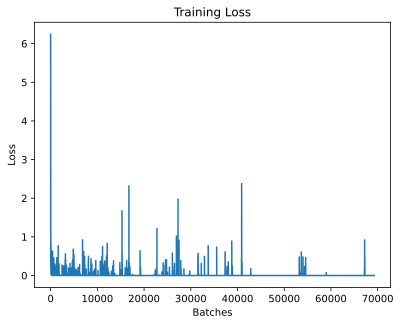

In [12]:
# Plot losses
plt.title('Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

In [13]:
# Validation
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # returns tuple of values tensor and index tensor
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on validation set: {100 * correct / total}%')

Accuracy on validation set: 99.99789515338017%


In [ ]:
# Input some example, non-existent strings and see if what the models predict for classifications

# Real
# 
# Fake

fakes = [
    "PWR-POX-4450",
    "PWR-POE-4460",
    "C9300-NM-9X",
    "D9300-NM-9X",
]

# Print the highest probability Labels for each Fake

with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    for fake in fakes:
        input = dataset.str_to_tensor(fake)
        input = input.unsqueeze(0)  # Add an extra dimension to convert it into a two-dimensional tensor
        output = model(input)
        probabilities = softmax(output)

        # Find the top 3 probabilities
        top_n = 3
        values, indices = probabilities.topk(top_n)
        values = values.squeeze()  # Remove outer dimension
        indices = indices.squeeze()  # Remove outer dimension
        
        print(f"For fake PID [{fake}] most likely product families with >10% probability are:")

        labels = [dataset.label_from_int(i) for i in indices]
        for p, l in zip(values, labels):
            if p > 0.1:
                print(f"  probability[{p:.2f}] of label[{l}]")